<a href="https://colab.research.google.com/github/Antoha2024/DiplomProductStar/blob/main/DS47_diabetes_ds_antipov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Гипотеза

- train test split 70/30, stratified
- Random state  - 654321
- Метрика - F1 Macro
- Метрики на train и test не должны сильно отличаться

Гипотеза: Уровень глюкозы в крови оказывает влияние на вероятность заболевания диабетом.
Гипотеза нулевая (H0): Нет разницы в среднем значении уровня глюкозы у пациентов с диабетом и без диабета.
Альтернативная гипотеза (HА​): Существует значительная разница в среднем уровне глюкозы у пациентов с диабетом и без диабета. Дополинтельно провести сравнительный анализ количества значимых признаков на уровень глюкозы для пожилых людей и имеющим высокие показатели ИМТ для градации 1 и 2 типа сахарного диабета.
Методы проверки: T-тест, F-test.
- Работы команды:

https://colab.research.google.com/drive/1JbX1YjDkzM0qKy7I5EC4jHoqy75E5rAY?usp=sharing

https://colab.research.google.com/drive/1GE2EVPu5BuNlCPwcSOiIJsPPXpC4jp0o?usp=sharing#scrollTo=mwPuGptrEyw-

- DS48 https://github.com/salfa-ru/ds41_50/blob/DS_48/DS48__diabetes_ds.ipynb

In [108]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


In [109]:
uploaded = files.upload()
df = pd.read_excel('diabetes_ds.xlsx')
#Переименование таргета, удаление в нём пропусков
df = df.rename(columns={r'Сахарный диабет (ЕСТЬ\НЕТ)' : 'Сахарный диабет'})
df = df.dropna(subset = ['Сахарный диабет']).reset_index(drop=True)
display(df.head(3), df.shape)

Saving diabetes_ds.xlsx to diabetes_ds.xlsx


,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,...,ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0


(478, 108)

In [110]:
df.info() #общая статистика

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Columns: 108 entries, Номер to Сахарный диабет
dtypes: float64(101), object(7)
memory usage: 403.4+ KB


In [111]:
#Показать список столбцов полностью
pd.set_option('display.max_rows', None)
print(df.dtypes)

Номер                                                                    float64
Перенес/ не перенес КВИ                                                  float64
Возраст                                                                  float64
Пол                                                                      float64
Рост, см                                                                 float64
Вес, кг                                                                  float64
ИМТ 2 (ФОРМУЛА EXCEL)                                                    float64
Эритроциты                                                               float64
Гемоглобин                                                               float64
Цветовой показатель                                                      float64
Лейкоциты                                                                float64
Лимфоциты%                                                               float64
ЛИМФОЦИТЫ, АБС (РАСЧЕТ ПО ФО

In [112]:
#Столбцы с типом object
obj_columns = df.columns[df.dtypes == 'object']
print(obj_columns)

Index(['BPB голеней',
       'Гипертрофия миокарда левого желудочка по ЭКГ или ЭХО-КГ (комментарий)',
       'Блокада НП Гисса', 'Блокада НП Гисса (комментарий)', 'AV- блокада',
       'ХБП (исходн)', 'ХСН по фракции выброса, %'],
      dtype='object')


Пустых значений: 0
Сахарный диабет
1.0    255
0.0    223
Name: count, dtype: int64


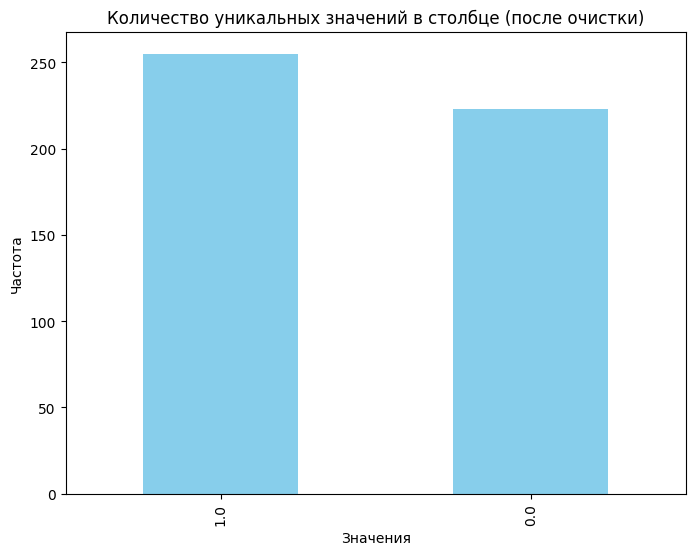

In [113]:
# Подсчет уникальных значений
value_counts = df['Сахарный диабет'].value_counts(dropna=False)

# Подсчет пустых значений
missing_count = df['Сахарный диабет'].isnull().sum()
print(f"Пустых значений: {missing_count}")

# Удаление строк с пустыми значениями
df_cleaned = df.dropna(subset=['Сахарный диабет'])

# Визуализация оставшихся данных
clean_value_counts = df_cleaned['Сахарный диабет'].value_counts()

# Печать очищенных данных
print(clean_value_counts)

# Построение графика
plt.figure(figsize=(8, 6))
clean_value_counts.plot(kind='bar', color='skyblue')
plt.title('Количество уникальных значений в столбце (после очистки)')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Вывод: Оценивая представленную информацию, можно сказать, что в наборе данных наблюдается умеренный дисбаланс классов:

Класс 1.0 («есть сахарный диабет») присутствует в количестве 255 случаев.
Класс 0.0 («нет сахарного диабета») составляет 223 случая.
Соотношение классов составляет примерно:

$$\frac{223}{255} \approx 1.14$$

То есть класс 1.0 представлен немного чаще, но дисбаланс невелик. Такой уровень дисбаланса считается приемлемым и не требует специальных мер по восстановлению равновесия классов.

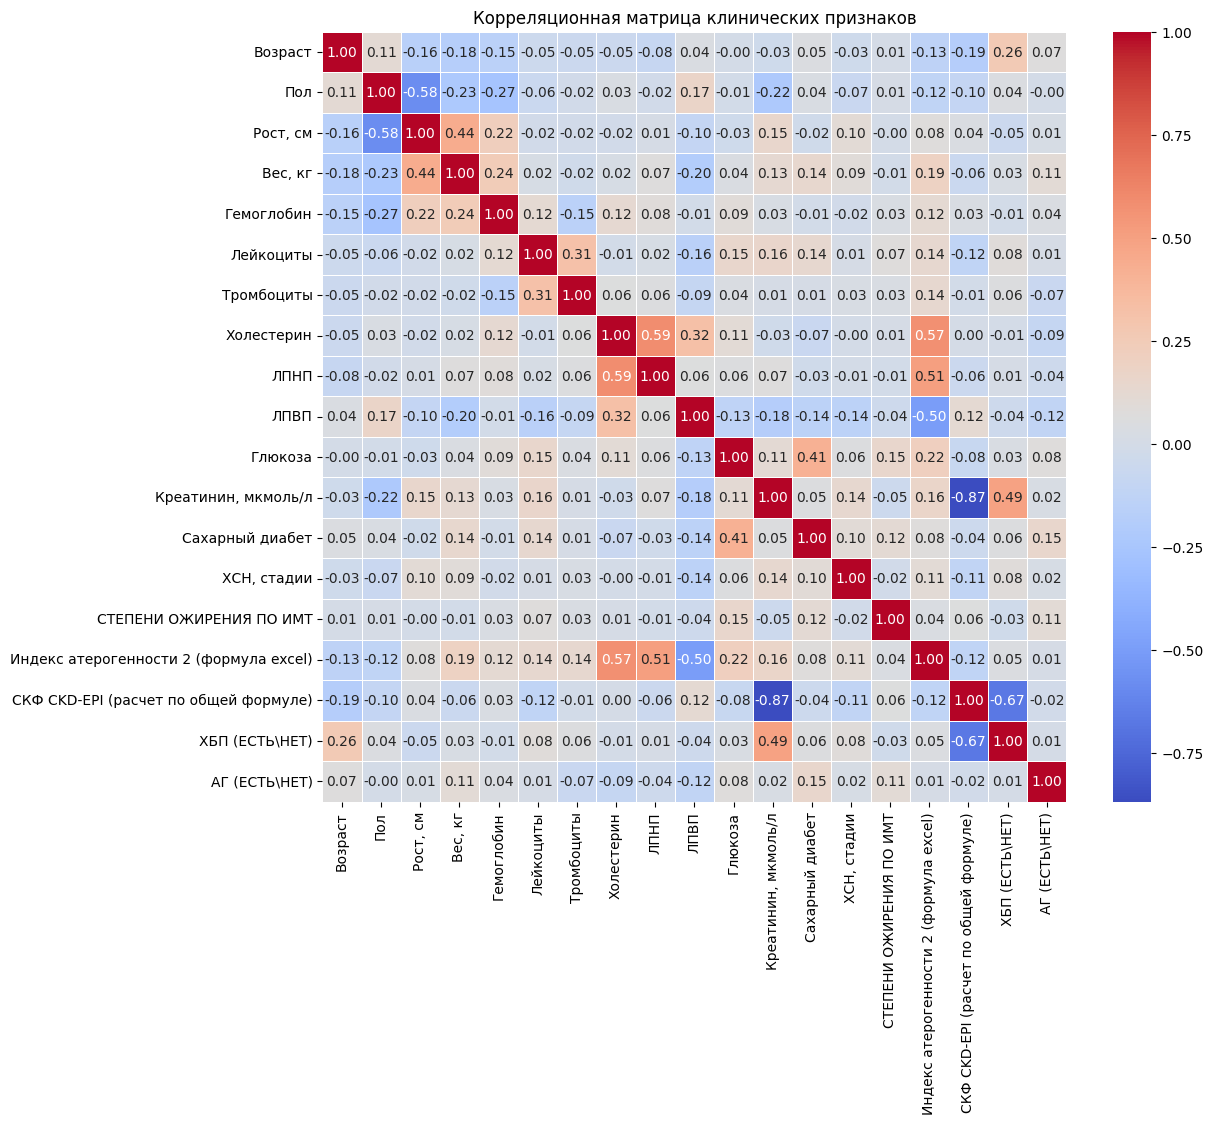

In [114]:
#Градация 1 и 2 типа сахарного диабета по уровню глюкозы
clinical_cols = [
    "Возраст",
    "Пол",
    "Рост, см",
    "Вес, кг",
    "Гемоглобин",
    "Лейкоциты",
    "Тромбоциты",
    "Холестерин",
    "ЛПНП",
    "ЛПВП",
    "Глюкоза",
    "Креатинин, мкмоль/л",
    "Сахарный диабет",
    "ХСН, стадии",
    "СТЕПЕНИ ОЖИРЕНИЯ ПО ИМТ",
    "Индекс атерогенности 2 (формула excel)",
    "СКФ CKD-EPI (расчет по общей формуле)",
    "ХБП (ЕСТЬ\\НЕТ)",
    "АГ (ЕСТЬ\\НЕТ)"
]

# Остаемся только с нужными признаками
selected_df = df[clinical_cols].copy()

# Замещаем NaN-значения на медианы соответствующего столбца
for column in clinical_cols:
    median_value = selected_df[column].median()
    selected_df[column].fillna(median_value, inplace=True)

# Матрица корреляции
corr_matrix = selected_df.corr()

# Рисуем тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=.5)
plt.title("Корреляционная матрица клинических признаков")
plt.show()

In [115]:
#print(df['Холестерин'].value_counts(dropna=False))
print(df['Холестерин'].mean())
print(df['Возраст'].mean())

4.116927472527473
61.74842767295598


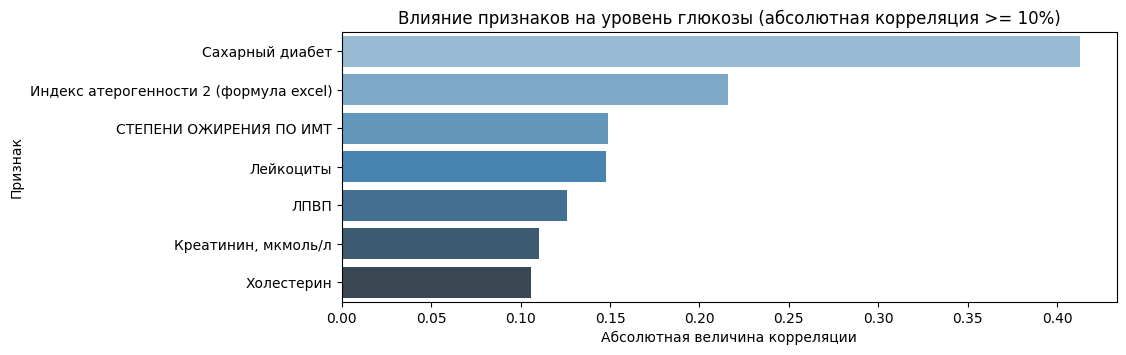

In [116]:
# Вычислим корреляцию
corr_matrix = selected_df.corr()

# Получим корреляцию по отношению к глюкозе
glucose_corr = corr_matrix['Глюкоза'].abs().sort_values(ascending=False)[1:]  # игнорируем само себя (корреляция 1.0)

# Отберём только признаки с абсолютной силой корреляции >= 10%
significant_features = glucose_corr[glucose_corr >= 0.1]

# Создание графика (горизонтальная гистограмма)
plt.figure(figsize=(10, len(significant_features)*0.5))  # высота зависит от количества признаков
sns.barplot(x=significant_features.values, y=significant_features.index, palette="Blues_d")
plt.xlabel("Абсолютная величина корреляции")
plt.ylabel("Признак")
plt.title("Влияние признаков на уровень глюкозы (абсолютная корреляция >= 10%)")
plt.show()

Вывод: В списке по влиянию на показатели глюкозы попали пациенты с высокой степенью ожирения, группа пожилых пациентов не попала, но повышенный холестерин в списке значимых показаний для глюкозы есть, как возможный возрастной фактор для 2 типа СД людей пожилого возраста. При этом средние показатели холестерина для признака Возраст ниже нормы, при том, что средний возраст более 60 лет.

# Обучение и прогнозирование

In [117]:
# Исходный список признаков

# Целевая переменная — наличие сахарного диабета
target_col = 'Сахарный диабет'
X = selected_df.drop(target_col, axis=1)
y = selected_df[target_col]

# Разделение на тренировочные и тестовые выборки (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=654321)

# Заполняем пустые значения медианой отдельно в тренировочной и тестовой выборках
for column in X_train.columns:
    if X_train[column].dtype != 'object':
        median_value_train = X_train[column].median()
        X_train[column].fillna(median_value_train, inplace=True)

        median_value_test = X_test[column].median()
        X_test[column].fillna(median_value_test, inplace=True)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [118]:
# Создание и обучение модели Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=654321)
rf_model.fit(X_train_scaled, y_train)

# Извлечение значений важности признаков
feature_importances = rf_model.feature_importances_

# Сохраняем названия признаков
features_names = X.columns.tolist()

# Формируем DataFrame для наглядности
importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
top_feature = importance_df.iloc[:10]

# Печать таблицы с признаками и уровнем их важности
print("Рейтинг признаков по влиянию на сахарный диабет:")
display(importance_df[:11])


Рейтинг признаков по влиянию на сахарный диабет:


,Feature,Importance
0,Глюкоза,0.256839
1,"Вес, кг",0.066457
2,ЛПНП,0.065786
3,Лейкоциты,0.065755
4,Тромбоциты,0.062814
5,Гемоглобин,0.058194
6,Индекс атерогенности 2 (формула excel),0.057529
7,СКФ CKD-EPI (расчет по общей формуле),0.055863
8,Холестерин,0.054600
9,"Креатинин, мкмоль/л",0.051457


In [119]:
def perform_t_tests(df, target_column):
    """
    Функция проводит t-тест для всех числовых признаков относительно целевого столбца.

    :param df: DataFrame с признаками и целевой переменной
    :param target_column: Название столбца с бинарной целевой переменной (0 или 1)
    """
    results = {}
    for col in df.select_dtypes(include=['float', 'int']).columns:
        if col != target_column:
            group_0 = df[col][df[target_column] == 0].dropna().values
            group_1 = df[col][df[target_column] == 1].dropna().values

            # Если обе группы содержат наблюдения
            if len(group_0) > 0 and len(group_1) > 0:
                t_statistic, p_value = ttest_ind(group_0, group_1)

                # Дополнительно проводим Levene Test для оценки гомоскедастичности (однородности дисперсий)
                levene_statistic, levene_p_value = levene(group_0, group_1)

                # Сохраняем все результаты
                results[col] = {
                    't-statistic': t_statistic,
                    'p-value': p_value,
                    'Levene statistic': levene_statistic,
                    'Levene p-value': levene_p_value
                }

    return results

In [120]:
# Используем вашу предыдущую реализацию с добавлением Levene Test
results = perform_t_tests(selected_df, target_col)

# Преобразуем результаты в DataFrame
final_results = pd.DataFrame(results).T

# Покажем результирующую таблицу
final_results

,t-statistic,p-value,Levene statistic,Levene p-value
Возраст,-1.051443,2.935887e-01,0.218461,6.404292e-01
Пол,-0.766913,4.435132e-01,0.588156,4.435132e-01
"Рост, см",0.535572,5.925048e-01,0.745556,3.883218e-01
"Вес, кг",-3.159666,1.680065e-03,0.015210,9.018978e-01
Гемоглобин,0.278026,7.811130e-01,2.822773,9.359185e-02
Лейкоциты,-3.024271,2.627007e-03,2.194894,1.391304e-01
Тромбоциты,-0.300747,7.637387e-01,2.143702,1.438161e-01
Холестерин,1.528604,1.270268e-01,2.545672,1.112605e-01
ЛПНП,0.616666,5.377498e-01,0.018135,8.929317e-01
ЛПВП,3.139209,1.799297e-03,3.468815,6.315195e-02


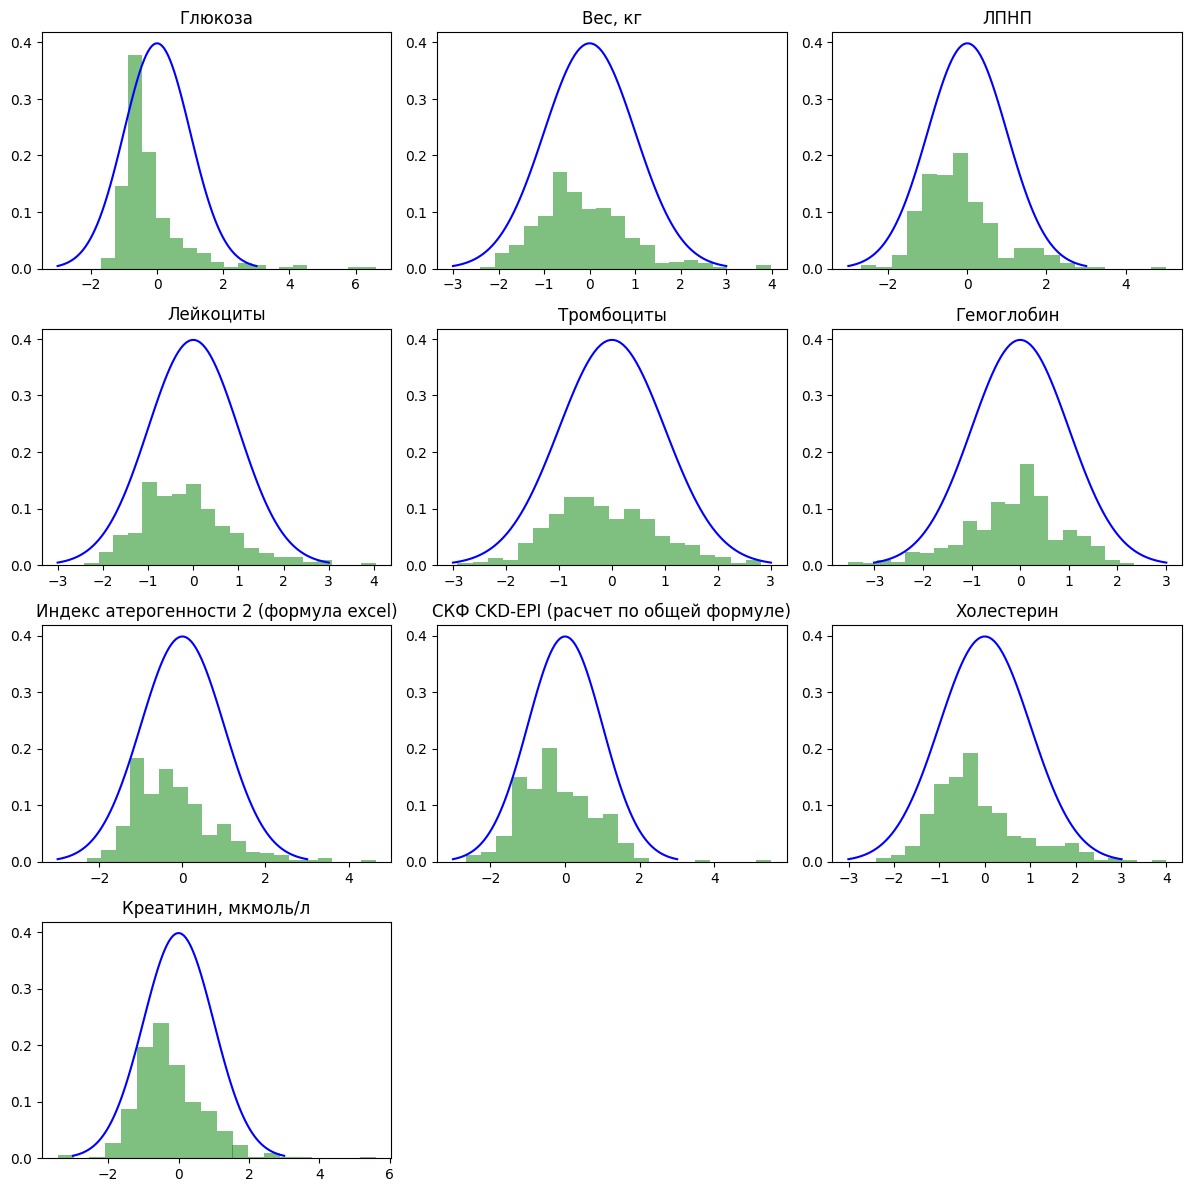

In [121]:
# Приводим X_train_scaled к формату DataFrame
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=X.columns)

# Объединяем признаки и цели
df = pd.concat([X_train_scaled_df, y_train], axis=1)

# Топ-10 признаков по важности
important_features = importance_df['Feature'].iloc[:10].tolist()

# Определим количество рядов и столбцов динамически
num_rows = int(np.ceil(len(important_features)/3))
num_cols = 3

# Создадим сетку графиков с правильным количеством рядов и столбцов
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows*3))

for idx, col_name in enumerate(important_features):
    row_idx = idx // num_cols
    col_idx = idx % num_cols

    data = df[col_name].dropna()  # Игнорируем NaN-значения
    mu = data.mean()
    sigma = data.std()

    # Генерация точек для графика
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    pdf = stats.norm.pdf(x, loc=mu, scale=sigma)

    # Кривая нормального распределения
    sns.lineplot(x=x, y=pdf, color='b', ax=axes[row_idx, col_idx])

    # Столбчатая диаграмма реальных данных
    bins = np.histogram_bin_edges(data, bins=20)
    counts, bin_edges = np.histogram(data, bins=bins)
    bar_width = bin_edges[1] - bin_edges[0]
    axes[row_idx, col_idx].bar(bin_edges[:-1], counts / len(data), width=bar_width, alpha=0.5, color='green')

    # Настройки подписей и оформления
    axes[row_idx, col_idx].set_title(col_name)
    axes[row_idx, col_idx].set_xlabel('')
    axes[row_idx, col_idx].set_ylabel('')

# Удаляем неиспользованные subplots
if len(important_features) % num_cols > 0:
    for j in range((len(important_features) % num_cols), num_cols):
        fig.delaxes(axes[num_rows-1, j])

plt.tight_layout(pad=1.0)
plt.show()

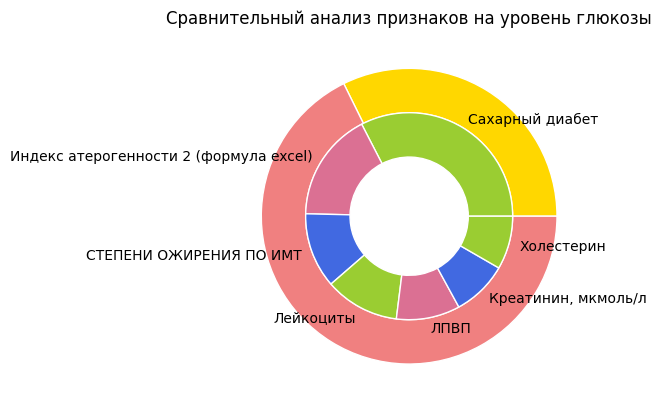

In [122]:
# Выберите семь главных признаков (количество совпадает с длиной significant_features)
top_feature = importance_df.iloc[:10]

# Фильтруем признаки с высоким влиянием на глюкозу
significant_features = glucose_corr[glucose_corr >= 0.1]

# Имена признаков берем из индекса Series
labels = significant_features.index.to_list()

# Сами значения важности
sizes = significant_features.values
sizes_1 = top_feature['Importance'].values

# Многослойная круговая диаграмма
fig, ax = plt.subplots()

# Устанавливаем размер внешнего кольца
size = 0.3

# Определяем цвета для слоев
outer_colors = ['gold', 'lightcoral', 'lightskyblue']
inner_colors = ['yellowgreen', 'palevioletred', 'royalblue']

# Наружное кольцо (суммарная доля первой половины признаков)
ax.pie([np.sum(sizes_1[:1]), np.sum(sizes_1[1:])], radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=['', ''])

# Внутреннее кольцо (детализация долей признаков)
ax.pie(sizes, radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels)

ax.set_aspect("equal")
plt.title('Cравнительный анализ признаков на уровень глюкозы', fontsize=12)
plt.show()

In [123]:
# Настройка логистической регрессии с L1-регуляризацией
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=654321)

# Обучение модели
model.fit(X_train_scaled, y_train)

# Прогнозирование класса на тестовой выборке
y_pred_test = model.predict(X_test_scaled)

# Прогнозирование класса на обучающей выборке
y_pred_train = model.predict(X_train_scaled)

# Матрицы ошибок
confusion_mat_train = confusion_matrix(y_train, y_pred_train)
confusion_mat_test = confusion_matrix(y_test, y_pred_test)

# Отчёт по классификации
classification_rep_train = classification_report(y_train, y_pred_train)
classification_rep_test = classification_report(y_test, y_pred_test)

# ROC-AUC
roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

# F1-macro
f1_macro_train = f1_score(y_train, y_pred_train, average="macro")
f1_macro_test = f1_score(y_test, y_pred_test, average="macro")

# Вывод итогов
print("\n=== ОБУЧАЮЩИЙ НАБОР ===\n")
print(classification_rep_train)
print("\nМатрица ошибок (Train):\n", confusion_mat_train)
print("\nROC-AUC (Train):", roc_auc_train)
print("\nF1-macro (Train):", f1_macro_train)

print("\n=== ТЕСТОВЫЙ НАБОР ===\n")
print(classification_rep_test)
print("\nМатрица ошибок (Test):\n", confusion_mat_test)
print("\nROC-AUC (Test):", roc_auc_test)
print("\nF1-macro (Test):", f1_macro_test)


=== ОБУЧАЮЩИЙ НАБОР ===

              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73       156
         1.0       0.78      0.71      0.74       178

    accuracy                           0.74       334
   macro avg       0.74      0.74      0.74       334
weighted avg       0.74      0.74      0.74       334


Матрица ошибок (Train):
 [[120  36]
 [ 52 126]]

ROC-AUC (Train): 0.821629213483146

F1-macro (Train): 0.736441893830703

=== ТЕСТОВЫЙ НАБОР ===

              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74        67
         1.0       0.78      0.74      0.76        77

    accuracy                           0.75       144
   macro avg       0.75      0.75      0.75       144
weighted avg       0.75      0.75      0.75       144


Матрица ошибок (Test):
 [[51 16]
 [20 57]]

ROC-AUC (Test): 0.7867803837953092

F1-macro (Test): 0.7495652173913043


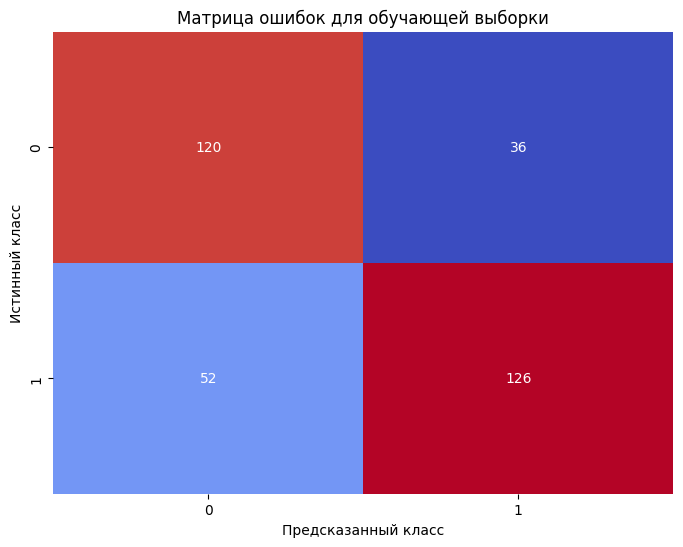

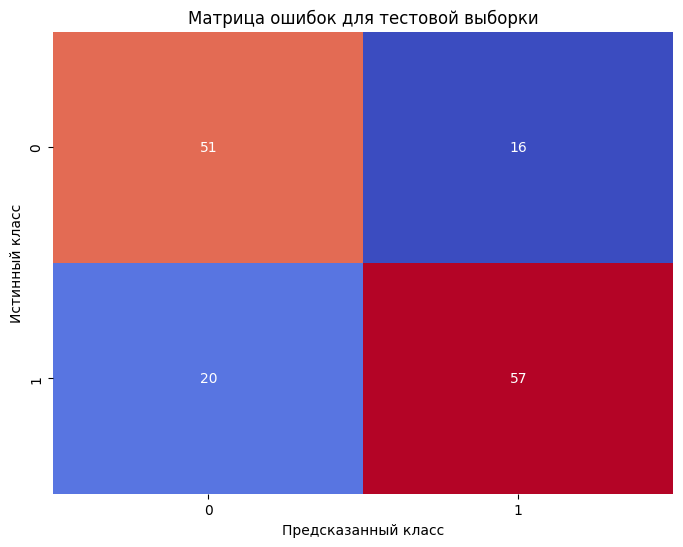

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Тепловая карта для обучающей выборки
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_train, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Матрица ошибок для обучающей выборки')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Тепловая карта для тестовой выборки
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Матрица ошибок для тестовой выборки')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()